# MODULES AND CONSTANTS

### MODULES, IMPORTS AND LIBRARIES

In [ ]:
# GENERAL IMPORTS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PLOTTING
import matplotlib.colors as colors
import matplotlib.cm as cmx

# PREPROCESSING
from sklearn.preprocessing import MinMaxScaler

# KMEANS
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN

# METRICS
from sklearn.metrics import silhouette_score, silhouette_samples


### CONSTANTS

In [170]:
INPUT_FILE = 'data.txt'

CLUSTERING_METHODS = [KMeans(n_clusters=14, random_state=42, tol=1e-8, max_iter=500, n_init=20),
                      BisectingKMeans(n_clusters=15, random_state=42, tol=1e-8, max_iter=500),
                      DBSCAN(eps=0.024, min_samples=17, n_jobs=-1)]

# DATASET LOAD

Load the synthetic 2-D dataset containing Gaussian clusters

In [ ]:
def readData(path:str)->pd.DataFrame:
    """reads a data file given the path

    Args:
        path (str): the path to the data file

    Returns:
        data (pd.DataFrame): the data read (they are normalized in between 0 and 1)
    """
    df = pd.read_csv(filepath_or_buffer=path, header=0)
    return pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

# DATA PLOTTING

Plot the data points as a scatter chart using the Matplotlib library. At first sight, you should see
15 different globular clusters. <br>Given this distribution, which could be the most suitable clustering
technique among the ones that you known? Why?

In [ ]:
def plotPoints(df:pd.DataFrame)->None:
    """plots the points on a scatter plot

    Args:
        df (pd.DataFrame): the dataframe to be plotted
    """
    plt.figure(figsize=(10,10))
    plt.scatter(df['x'], df['y'])
    plt.show()

# KMEANS ALGORITHM

Runs the various Kmeans algorithm on the given dataset

In [ ]:
def findClusters(df:pd.DataFrame, methods:list[KMeans]|KMeans=CLUSTERING_METHODS)->list[pd.DataFrame, dict]:
    """finds the possible clusters for the given data

    Args:
        df (pd.DataFrame): the dataFrame to be divided in clusters
        methods (list[KMeans] | KMeans, optional): The list of clusters algorithm to be used. Defaults to CLUSTERING_METHODS.

    Returns:
        df (list[pd.DataFrame, dict]): the augmented df with the clustering results and the dict of centroids when possible
    """
    methods:list[KMeans] = [methods] if not isinstance(methods, list) else methods
    centroids = {}
    
    for method in methods:
        name = method.__str__().split("(")[0]
        df[name] =  method.fit_predict(df[['x', 'y']])
        try:
            centroids[name] = method.cluster_centers_
        except AttributeError:
            pass
        
    return df, centroids

# PLOT RESULTS

Plots the results of the clustering for a given set of points

In [ ]:
def plotClusteringResults(df:pd.DataFrame, centroids:dict)->None:
    """plots the clustering results per each clustering method

    Args:
        df (pd.DataFrame): the dataframe of measures
        centroids (dict): the centroids found (if the methods supports that)
    """
    columns:np = df.columns.difference(['x', 'y']).sort_values()
    
    fig, ax = plt.subplots(columns.shape[0], 1, figsize=(15, 15*columns.shape[0]))
    
    for i in range(columns.shape[0]):
        scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=df[columns[i]].min(), vmax=df[columns[i]].max()), 
                                    cmap=plt.get_cmap('tab20'))

        ax[i].scatter(x=df['x'], y=df['y'], c=scalarMap.to_rgba(df[columns[i]]))
        if columns[i] in centroids:
            ax[i].scatter(x=centroids[columns[i]][:, 0], y=centroids[columns[i]][:, 1], color=[0,0,0,1], marker='*')
            
        ax[i].set_title(f'Method {columns[i]}')


# SILHOUETTE SCORE

Evaluates the obtained silhouette score for each different cluster method.<br>

Implement a function to plot the silhouette values sorted in ascending order. This kind of chart is
particularly useful to inspect the overall performance of a clustering technique. <br>In an ideal case, the
curve is heavily shifted towards the value 1 on the y-axis, i.e. most of the points have been assigned
coherently. <br> Create the chart for both your datasets and discuss the results. <br> Do these plots match
the clustering performance that you expected looking at the scatter plots from the previous exercise,
point 5? 

In [ ]:
def evaluateSilhouetteScore(df:pd.DataFrame, plotData:bool=True)->pd.DataFrame:
    columns:np = df.columns.difference(['x', 'y']).sort_values()
    
    if plotData:
        fig, ax = plt.subplots(columns.shape[0], 1, figsize=(15, 15*columns.shape[0]))
        
        for i in range(columns.shape[0]):
            sil:np = silhouette_samples(df[['x', 'y']], df[columns[i]])
            ax[i].plot(list(range(sil.shape[0])), sorted(sil))
            ax[i].set_title(f'Method {columns[i]}')
            
    try:
        return pd.DataFrame([silhouette_score(df[['x', 'y']], labels=df[col]) for col in columns], columns=['value'], index=columns).T
    except Exception:
        return pd.DataFrame([-1000])

# VARYING SILHOUETTE BY K MEANS

Define a function that, given a set of K values and a dataset, plots a line chart with the values of the
average silhouette obtained for each K. By simply looking at it, you should be able to identify the
best K for the task. <br>Is it the one that you expected beforehand? Can you spot a trend (e.g. the higher
the K value the higher the average silhouette)? Discuss this especially for the Chameleon dataset.


In [ ]:
def testSilhouetteScoreByKMeans(df:pd.DataFrame, start:int=2, stop:int=30) -> None:
    start = max(start, 2)

    fig, ax = plt.subplots(1,1,figsize=(20,10))

    ax.plot(
        list(range(start, stop)),
        [ silhouette_score(df[['x', 'y']], labels=KMeans(n_clusters=i, random_state=42, tol=1e-8, max_iter=500).fit_predict(df[['x', 'y']]))
            for i in range(start, stop)],
        '-*'
        )
    ax.grid(True)
    ax.set_xticks(list(range(start-1, stop+1)))
    ax.set_ylim(0, 1)
    ax.set_title('Avg silhouette score by number of cluster value')
    ax.set_xlabel("number of clusters")
    ax.set_ylabel("silhouette score value")
    plt.show()

# MAIN FUNCTION

This is the main function of the program, it does:
<ol>
<li>Loads the dataset as a dataframe</li>
<li>Plots the found points on the graph</li>
<li>Performs KMeans algorithm on the Data</li>
<li>Plots the clusters found</li>
<li>Evaluates the obtained silhouette score</li>
<li>Evaluates the various average silhouette score obtained for k varying </li>
</ol>

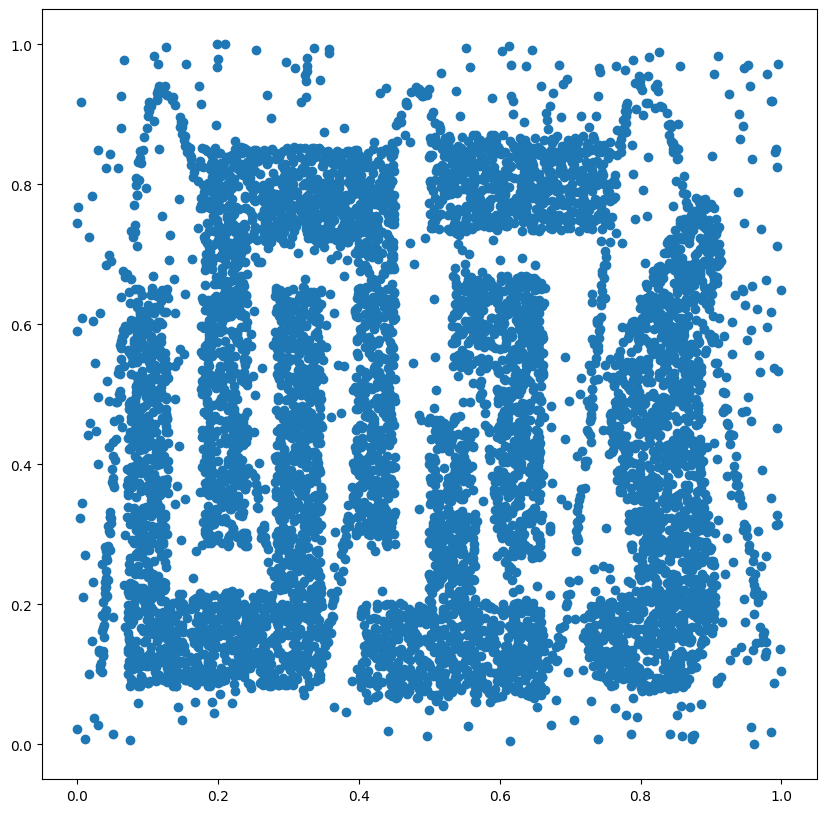

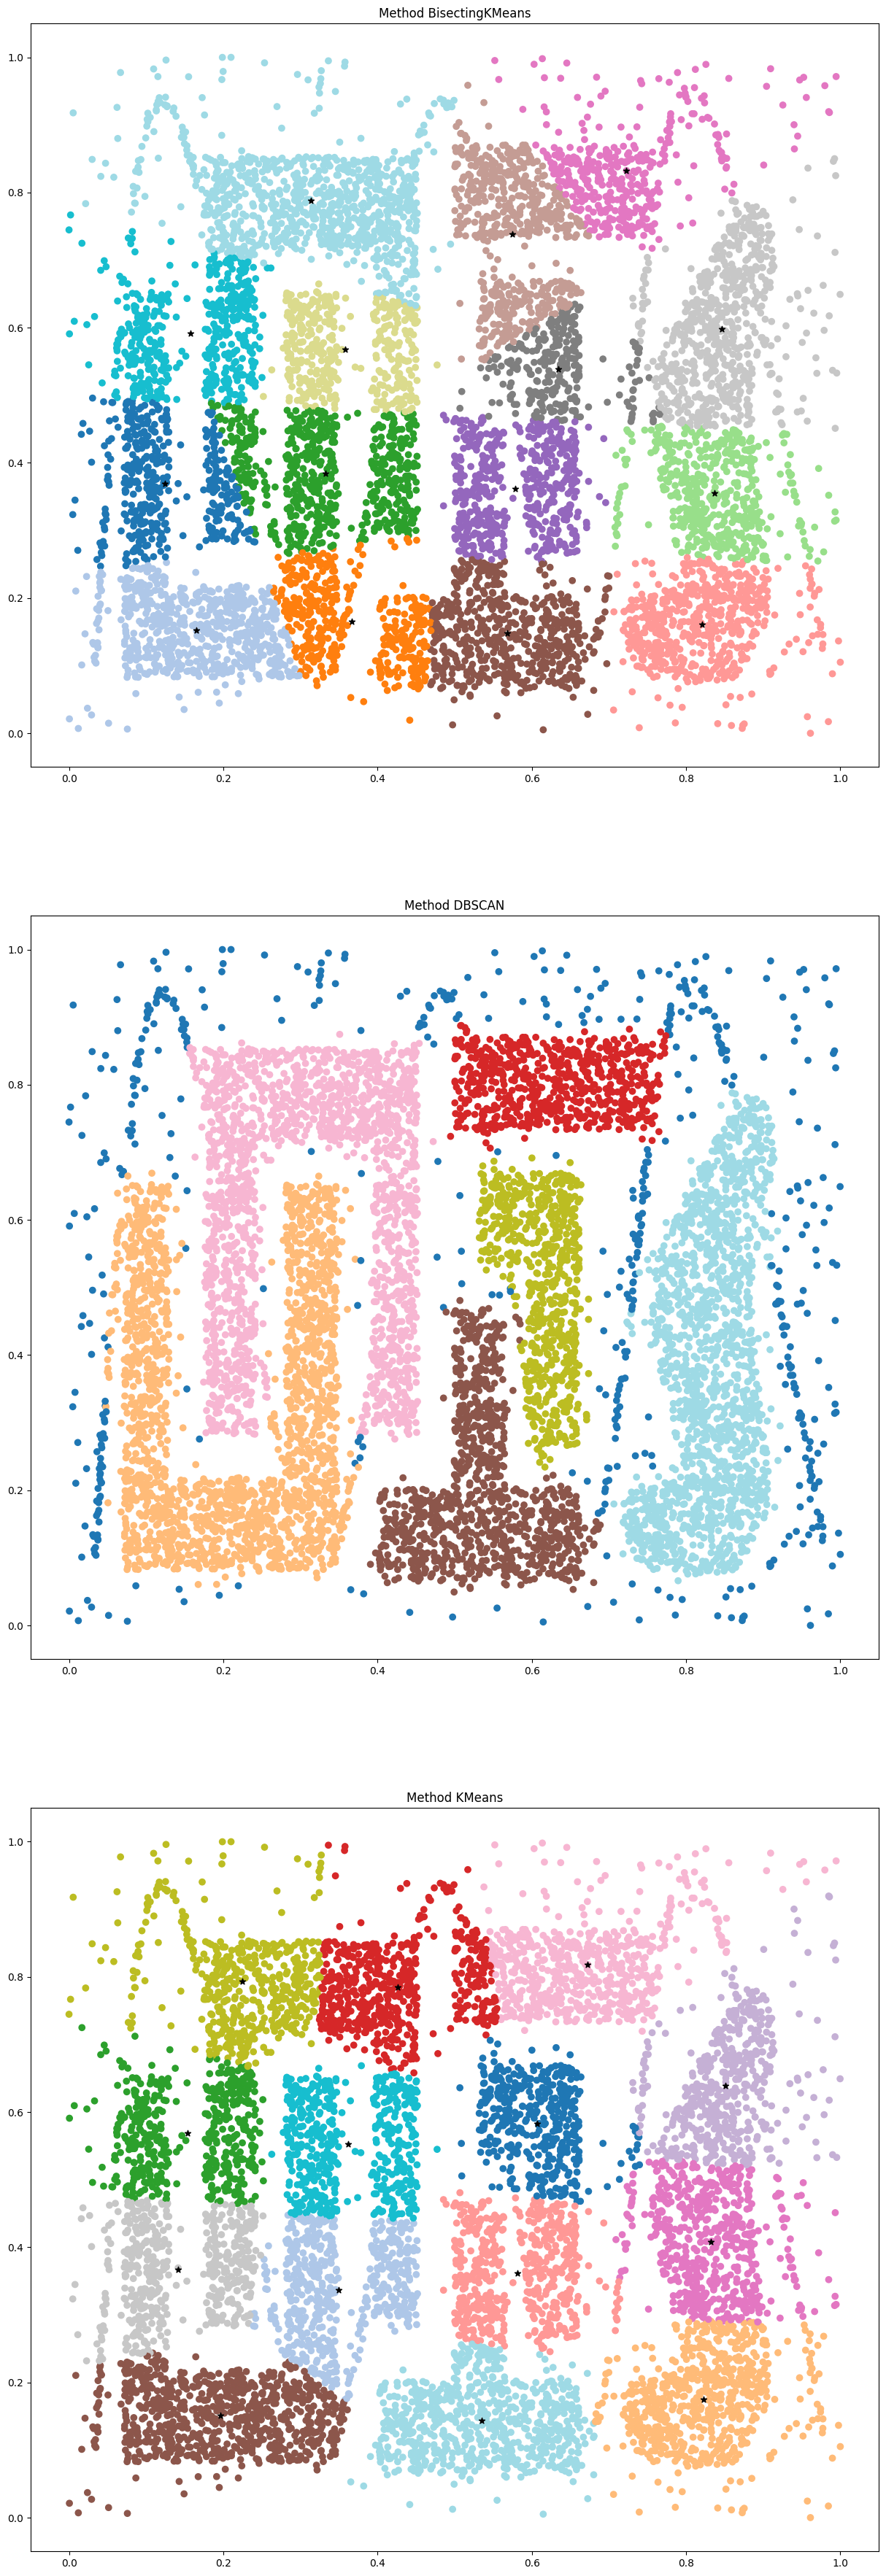

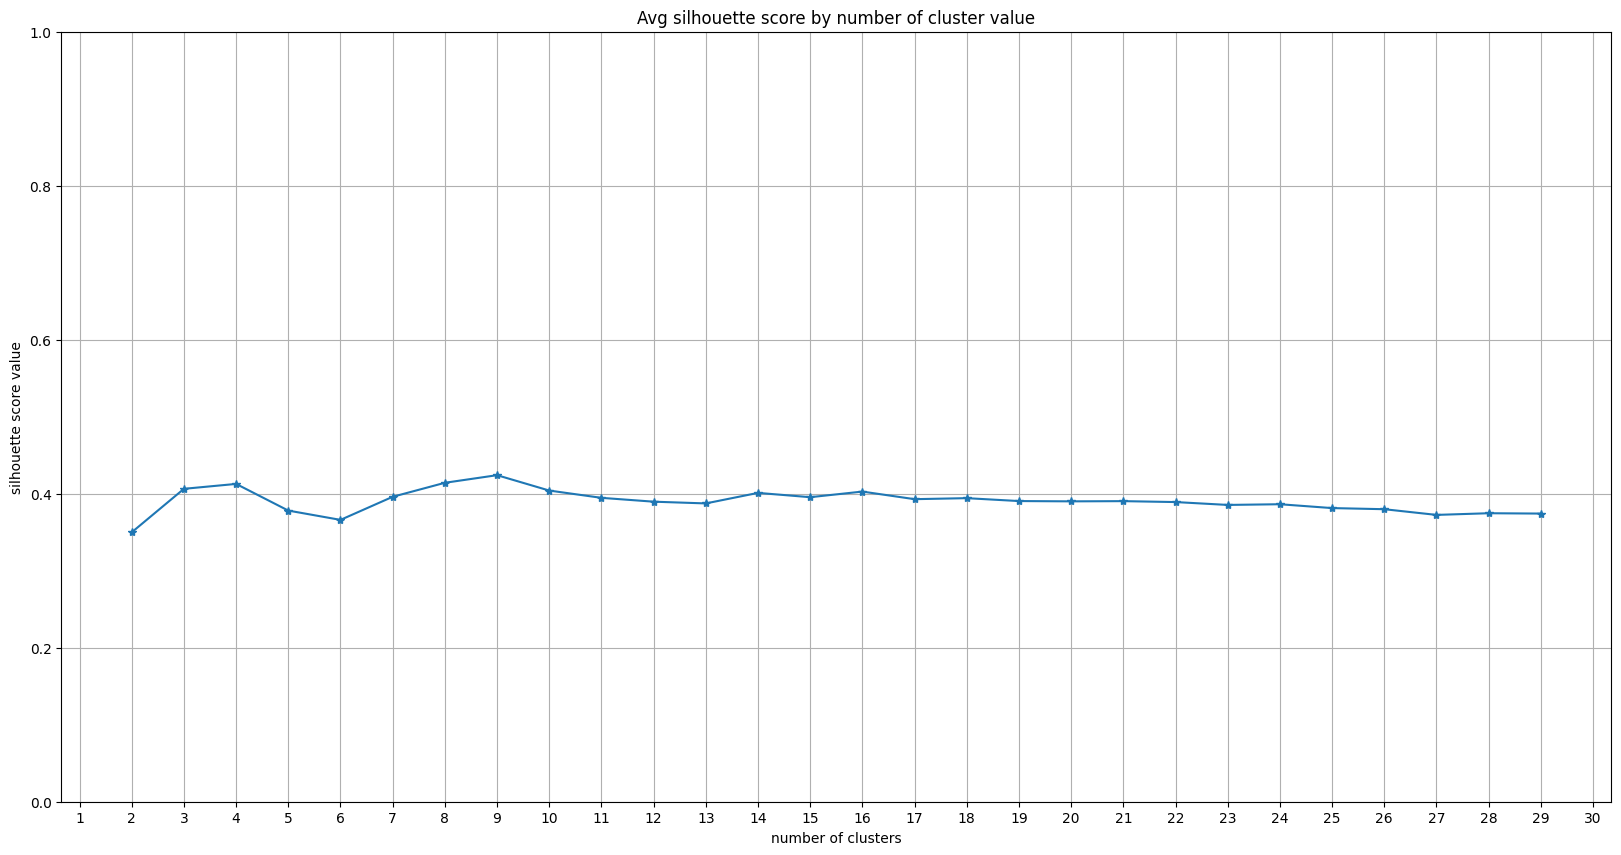

In [171]:
def main()->None:
    df = readData(INPUT_FILE) # 1
    plotPoints(df) # 2
    df, centroids = findClusters(df, CLUSTERING_METHODS) # 3
    plotClusteringResults(df, centroids) # 4
    evaluateSilhouetteScore(df, False) # 5
    testSilhouetteScoreByKMeans(df, start=2, stop=30) # 6
    
    
main()

# DBSCAN HYPERPARAMETERS

In [168]:

df = readData(INPUT_FILE) # 1
#plotClusteringResults(df, centroids) # 4
from sklearn.model_selection import ParameterGrid

eps = list(map(lambda x: x/1000, list(range(10, 300))))
minSample = list(range(5, 20))


minimum = -1
counter = 0
limit = (25-10)*(20-8)

for comb in ParameterGrid(
                        {'eps':list(map(lambda x: x/1000, list(range(10, 25)))),
                        'minSample':list(range(8, 20))}):
    df, centroids = findClusters(df, DBSCAN(eps=comb['eps'], min_samples=comb['minSample'], n_jobs=-1)) # 3  
    ris = evaluateSilhouetteScore(df, False)
    if float(ris.iloc[0, 0]) > minimum:
        val_eps = comb['eps']
        minSampe = comb['minSample']
        minimum = float(ris.iloc[0,0])
    
    counter+=1
    print(f'{counter} out of {limit} ')

1 out of 180 
2 out of 180 
3 out of 180 
4 out of 180 
5 out of 180 
6 out of 180 
7 out of 180 
8 out of 180 
9 out of 180 
10 out of 180 
11 out of 180 
12 out of 180 
13 out of 180 
14 out of 180 
15 out of 180 
16 out of 180 
17 out of 180 
18 out of 180 
19 out of 180 
20 out of 180 
21 out of 180 
22 out of 180 
23 out of 180 
24 out of 180 
25 out of 180 
26 out of 180 
27 out of 180 
28 out of 180 
29 out of 180 
30 out of 180 
31 out of 180 
32 out of 180 
33 out of 180 
34 out of 180 
35 out of 180 
36 out of 180 
37 out of 180 
38 out of 180 
39 out of 180 
40 out of 180 
41 out of 180 
42 out of 180 
43 out of 180 
44 out of 180 
45 out of 180 
46 out of 180 
47 out of 180 
48 out of 180 
49 out of 180 
50 out of 180 
51 out of 180 
52 out of 180 
53 out of 180 
54 out of 180 
55 out of 180 
56 out of 180 
57 out of 180 
58 out of 180 
59 out of 180 
60 out of 180 
61 out of 180 
62 out of 180 
63 out of 180 
64 out of 180 
65 out of 180 
66 out of 180 
67 out of 180 
68 o

In [169]:
val_eps, minSampe, minimum

(0.024, 17, 0.17364154832256587)